In [ ]:
!pip install praw
!pip install --upgrade numpy
!pip install --upgrade scipy
!pip install --upgrade gensim
!pip install pyLDAvis

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.6 MB)
  A

In [ ]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import praw
import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from datetime import datetime
import matplotlib.dates as mdates
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.lda_model
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# NLTK downloads

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Reddit API Authentication

reddit = praw.Reddit(client_id="",
                     client_secret="",
                     user_agent="")

In [ ]:
# Data Collection Parameters

subreddits = ["personalfinance", "unemployment"]
search_terms = ["rent", "debt", "job loss", "inflation"]

# Timeframe: Oct 1, 2022 to Mar 31, 2023

start_timestamp = int(datetime(2022, 10, 1).timestamp())
end_timestamp = int(datetime(2023, 3, 31).timestamp())

In [ ]:
# Convert Reddit timestamp to readable date

def convert_timestamp(timestamp):
    return datetime.fromtimestamp(timestamp).astimezone().strftime('%Y-%m-%d')

In [ ]:
# Post collection

post_data = []

for subreddit_name in subreddits:
    subreddit = reddit.subreddit(subreddit_name)
    for query in search_terms:
        for submission in subreddit.search(query, limit=100, sort='top', time_filter='all'):
            post_timestamp = submission.created_utc
            if start_timestamp <= post_timestamp <= end_timestamp and submission.num_comments >= 100:
                post_data.append([
                    submission.id,
                    submission.title,
                    submission.author.name if submission.author else "[deleted]",
                    submission.created_utc,
                    convert_timestamp(post_timestamp),
                    submission.url,
                    submission.num_comments,
                    submission.score
                ])

# Convert to DataFrame

posts_df = pd.DataFrame(post_data, columns=[
    'Submission ID', 'Title', 'Author', 'Created UTC', 'Post Date', 'URL', 'Comment Count', 'Upvotes'
])

posts_df.to_excel('financial_anxiety_posts_for_selection.xlsx', index=False)

print(f"Posts saved for manual selection. Total posts retrieved: {len(posts_df)}")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Posts saved for manual selection. Total posts retrieved: 17


In [ ]:
# Manually Selected Post IDs

SELECTED_POST_IDS = {
    '11yqgoo','10gvh92','yrlft9','zj6upj','yf0ido','1182vyw','ygv6mv'
}

In [ ]:
# Initialize tools

lemmatizer = WordNetLemmatizer()

In [ ]:
# Text Cleaning Function

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words) if words else None

In [ ]:
# Data Extraction

comment_data = []

for post_id in SELECTED_POST_IDS:
    submission = reddit.submission(id=post_id)
    print(f"\nProcessing Post: {submission.title} | Comments: {submission.num_comments}")

    submission.comments.replace_more(limit=0)
    top_comments = [comment for comment in submission.comments if comment.body not in ["[deleted]", "[removed]"]]

    if len(top_comments) < 150:
        replies = []
        for comment in top_comments:
            replies.extend([reply for reply in comment.replies if hasattr(reply, 'body') and reply.body not in ["[deleted]", "[removed]"]])
        top_comments.extend(replies)

    selected_comments = sorted(top_comments, key=lambda c: c.created_utc)[:150]

    print(f"Collected {len(selected_comments)} comments")

    for comment in selected_comments:
        cleaned = clean_text(comment.body)
        if cleaned:
            comment_data.append([
                submission.id,
                comment.id,
                comment.author.name if comment.author else "[deleted]",
                comment.created_utc,
                convert_timestamp(comment.created_utc),
                submission.title,
                submission.url,
                submission.num_comments,
                submission.score,
                comment.body,
                cleaned
            ])

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




Processing Post: Accepted a job offer right before a company wide inflation raise | Comments: 476
Collected 150 comments


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




Processing Post: Should we cancel our wedding due to financial burden/risk of debt? | Comments: 1732
Collected 150 comments


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




Processing Post: Should I appeal the tax assessment on my home? | Comments: 408
Collected 150 comments


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




Processing Post: Is it inappropriate to include inflation as one of the factors ( including performance) when asking for a raise? | Comments: 542
Collected 150 comments


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




Processing Post: WTH Geico? 40% Increase? | Comments: 806
Collected 150 comments


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




Processing Post: My dad (72) died unexpectedly last month and left barely any money behind for my mom (62). What do I (27) do? I'm beginning to panic. | Comments: 1093
Collected 150 comments


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




Processing Post: Can someone give me an idea of why I suddenly owe so much taxes? | Comments: 688
Collected 150 comments


In [ ]:
# Convert to DataFrame

comments_df = pd.DataFrame(comment_data, columns=[
    'Submission ID', 'Comment ID', 'Comment Author', 'Comment UTC', 'Comment Date',
    'Post Title', 'Post URL', 'Total Comments', 'Post Score',
    'Original Comment', 'Cleaned Comment'
])

comments_df.to_csv("financial_anxiety_cleaned_comments.csv", index=False)

print(f"\nSaved {len(comments_df)} comments across all selected posts.")


Saved 1050 comments across all selected posts.


In [ ]:
# Tokenize Cleaned Comments

tokenized_docs = [text.split() for text in comments_df['Cleaned Comment'].dropna()]

In [ ]:
# Vectorize using CountVectorizer

vectorizer = CountVectorizer(
    stop_words='english',
    lowercase=True,
    min_df=5,
    max_df=0.9,
    token_pattern=r'\b[a-zA-Z]{3,}\b'
)
doc_term_matrix = vectorizer.fit_transform([' '.join(doc) for doc in tokenized_docs])
feature_names = vectorizer.get_feature_names_out()

In [ ]:
coherence_scores = []
topic_range = range(2, 11)

# Gensim Dictionary and Corpus

gensim_dict = Dictionary(tokenized_docs)
gensim_corpus = [gensim_dict.doc2bow(text) for text in tokenized_docs]

for k in topic_range:

    # Train LDA model with k topics

    lda_model_k = LatentDirichletAllocation(n_components=k, random_state=42)
    doc_term_matrix = vectorizer.fit_transform([' '.join(doc) for doc in tokenized_docs])
    lda_model_k.fit(doc_term_matrix)

    # Top words per topic

    feature_names = vectorizer.get_feature_names_out()
    topics = []
    for topic in lda_model_k.components_:
        top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
        topics.append(top_words)

    # Coherence

    coherence_model = CoherenceModel(
        topics=topics, texts=tokenized_docs,
        dictionary=gensim_dict, coherence='c_v'
    )
    score = coherence_model.get_coherence()
    coherence_scores.append(score)
    print(f"k={k}, Coherence Score: {score:.4f}")

k=2, Coherence Score: 0.4390
k=3, Coherence Score: 0.4343
k=4, Coherence Score: 0.4971
k=5, Coherence Score: 0.6229
k=6, Coherence Score: 0.5766
k=7, Coherence Score: 0.6613
k=8, Coherence Score: 0.6207
k=9, Coherence Score: 0.5799
k=10, Coherence Score: 0.5494


In [ ]:
# Train LDA Model

lda_model = LatentDirichletAllocation(n_components=7, random_state=42)
lda_model.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=7, random_state=42)

In [ ]:
# Display Topics

def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\n--- Topic {topic_idx + 1} ---")
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        print(" ".join(top_words))

display_topics(lda_model, feature_names, 10)


--- Topic 1 ---
tax year job withholding income new refund owe pay check

--- Topic 2 ---
year tax value appeal house property home assessment county time

--- Topic 3 ---
wedding money married party debt family friend day people want

--- Topic 4 ---
inflation company raise increase cost pay work market want value

--- Topic 5 ---
raise ask company job dont offer year got like pay

--- Topic 6 ---
geico insurance year rate month progressive car price state shop

--- Topic 7 ---
house sell mom rent mortgage need year make home like


In [ ]:
# Topic Labels

topic_labels = {
    'Topic 1': 'Tax and Income',
    'Topic 2': 'Property Assessments',
    'Topic 3': 'Life Events and Family Expenses',
    'Topic 4': 'Inflation and Salary Concerns',
    'Topic 5': 'Job Offers and Negotiations',
    'Topic 6': 'Insurance and Premiums',
    'Topic 7': 'Housing and Rent Stress'
}

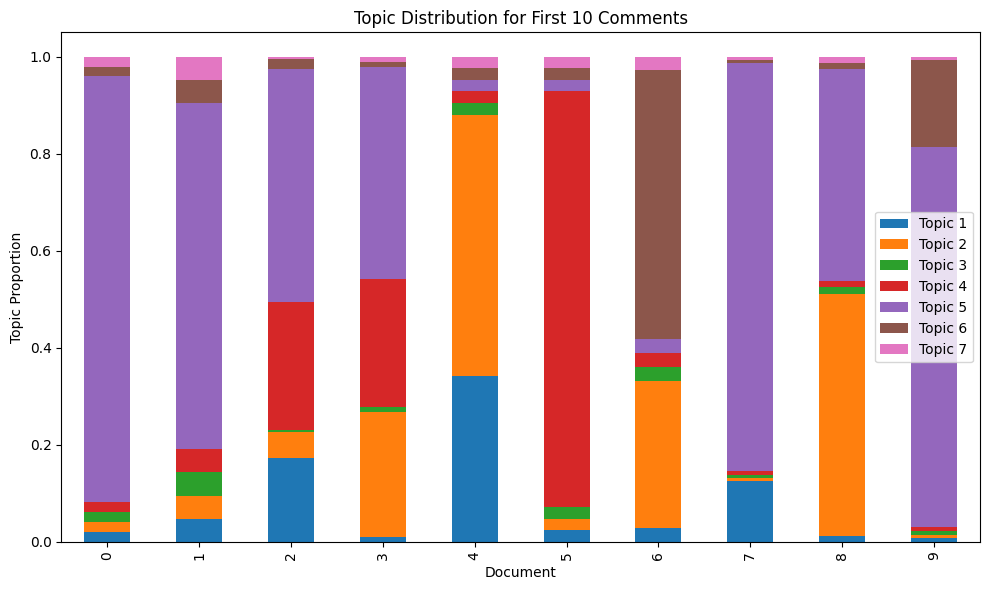

In [ ]:
# Visualize Topic Distribution for First 10 Comments

topic_distributions = lda_model.transform(doc_term_matrix)
df_topics = pd.DataFrame(topic_distributions, columns=[f"Topic {i+1}" for i in range(lda_model.n_components)])

df_topics.iloc[:10].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Topic Distribution for First 10 Comments")
plt.xlabel("Document")
plt.ylabel("Topic Proportion")
plt.tight_layout()
plt.show()

In [ ]:
# Visualize Topics using pyLDAvis

pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda_model, doc_term_matrix, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      11.659625 -80.326408       1        1  20.500304
1     -71.057076  10.428544       2        1  17.665263
4      -3.429492 -11.015635       3        1  17.548674
2      64.312683 -32.712353       4        1  13.730343
0     -18.741177  58.414639       5        1  11.919930
3      48.963497  36.727402       6        1  11.694329
5     -56.108208 -58.960331       7        1   6.941156, topic_info=          Term        Freq       Total Category  logprob  loglift
959    wedding  276.000000  276.000000  Default  30.0000  30.0000
883        tax  349.000000  349.000000  Default  29.0000  29.0000
457  inflation  174.000000  174.000000  Default  28.0000  28.0000
433      house  301.000000  301.000000  Default  27.0000  27.0000
178    company  206.000000  206.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
414     higher   13.996943   68.495735   Topic7  -4.7124   1.0798
501       like   18.541141  196.638392   Topic7  -4.4312   0.3063
473        ive   12.698100   53.229716   Topic7  -4.8098   1.2345
376      going   13.898112  113.853247   Topic7  -4.7195   0.5645
178    company   14.021366  206.493083   Topic7  -4.7106  -0.0220

[435 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5         3  0.932130  accepted
6         7  0.901167  accident
12        1  0.111494  actually
12        2  0.066896  actually
12        3  0.111494  actually
...     ...       ...       ...
999       2  0.074561     youre
999       3  0.438045     youre
999       4  0.121161     youre
999       5  0.130481     youre
999       6  0.130481     youre

[844 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 5, 3, 1, 4, 6])

In [ ]:
# Sentiment labels

def get_sentiment_label(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.05:
        return 'Coping'
    elif polarity < -0.05:
        return 'Anxious'
    else:
        return 'Neutral'

comments_df['Sentiment Label'] = comments_df['Cleaned Comment'].apply(get_sentiment_label)
print(comments_df['Sentiment Label'].value_counts())

comments_df.to_csv("financial_anxiety_labeled_comments.csv", index=False)

Sentiment Label
Coping     555
Neutral    335
Anxious    160
Name: count, dtype: int64


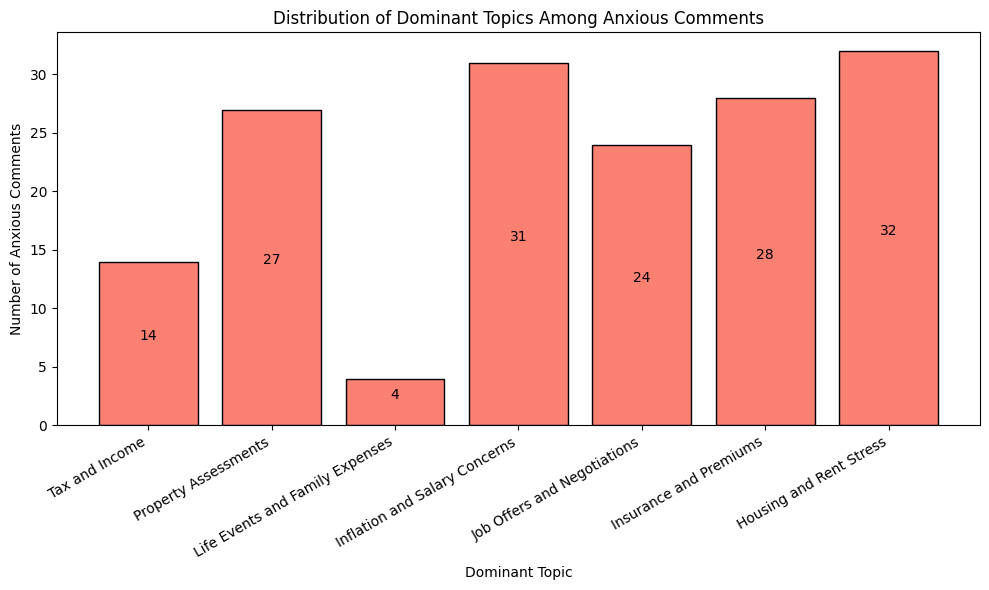

In [ ]:
# Distribution of Dominant Topics Among Anxious Comments

df_topics = pd.DataFrame(topic_distributions, columns=[f"Topic {i+1}" for i in range(lda_model.n_components)])

dominant_topic = df_topics.idxmax(axis=1)
comments_df['Dominant Topic'] = dominant_topic

anxious_comments = comments_df[comments_df['Sentiment Label'] == 'Anxious']

anxious_topic_counts = anxious_comments['Dominant Topic'].value_counts().sort_index()

anxious_topic_counts.index = [topic_labels.get(topic, topic) for topic in anxious_topic_counts.index]

plt.figure(figsize=(10, 6))
bars = plt.bar(anxious_topic_counts.index, anxious_topic_counts.values, color='salmon', edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height/2, str(int(height)), ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Dominant Topics Among Anxious Comments")
plt.xlabel("Dominant Topic")
plt.ylabel("Number of Anxious Comments")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Filter Out Neutral Comments

df_binary = comments_df[comments_df['Sentiment Label'].isin(['Coping', 'Anxious'])].copy()

# Balance Classes by Upsampling Minority Class

from sklearn.utils import resample

coping_df = df_binary[df_binary['Sentiment Label'] == 'Coping']
anxious_df = df_binary[df_binary['Sentiment Label'] == 'Anxious']

anxious_upsampled = resample(anxious_df,
                             replace=True,
                             n_samples=len(coping_df),
                             random_state=42)

balanced_df = pd.concat([coping_df, anxious_upsampled])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n-- Balanced Class Counts --")
print(balanced_df['Sentiment Label'].value_counts())

# TF-IDF Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer

X = balanced_df['Cleaned Comment']
y = balanced_df['Sentiment Label']

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = vectorizer.fit_transform(X)

# Train/Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.3, random_state=42, stratify=y
)

# Train Logistic Regression Classifier

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluate Model Performance

from sklearn.metrics import classification_report, confusion_matrix

print("\n-- Classification Report --")
print(classification_report(y_test, y_pred))

print("\n-- Confusion Matrix --")
print(confusion_matrix(y_test, y_pred))


-- Balanced Class Counts --
Sentiment Label
Anxious    555
Coping     555
Name: count, dtype: int64

-- Classification Report --
              precision    recall  f1-score   support

     Anxious       0.86      0.94      0.90       167
      Coping       0.93      0.84      0.89       166

    accuracy                           0.89       333
   macro avg       0.90      0.89      0.89       333
weighted avg       0.90      0.89      0.89       333


-- Confusion Matrix --
[[157  10]
 [ 26 140]]


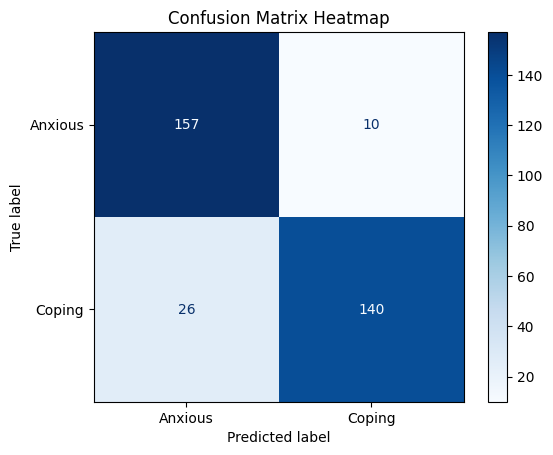

In [ ]:
# Confusion Matrix Heatmap

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix Heatmap")
plt.show()

In [ ]:
# Most Important Features

feature_names = vectorizer.get_feature_names_out()
coefficients = clf.coef_[0]

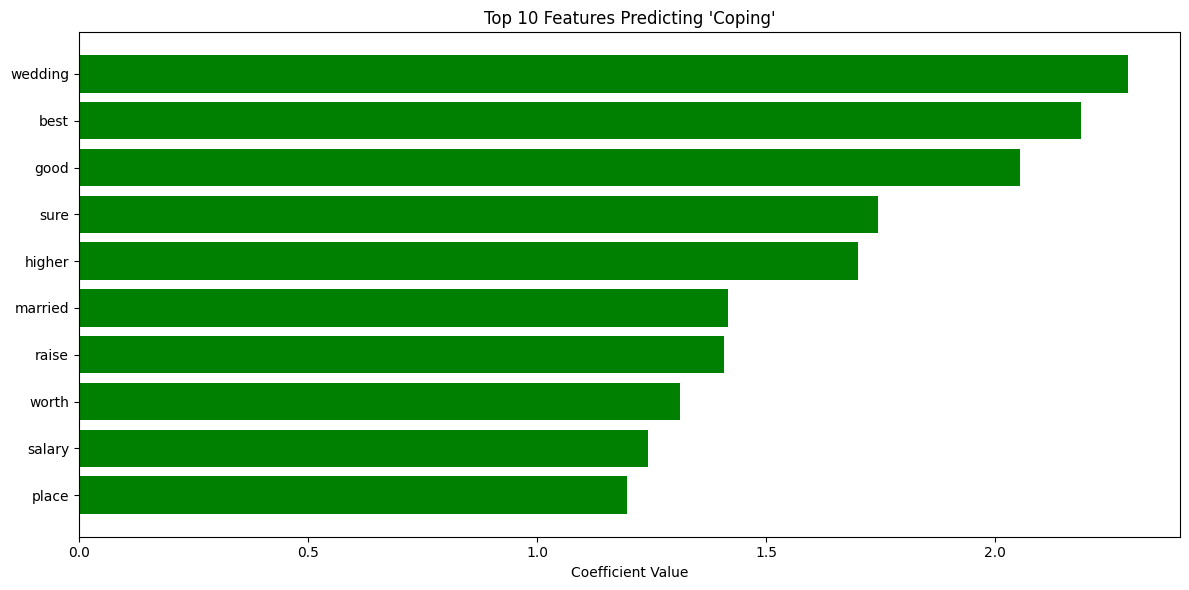

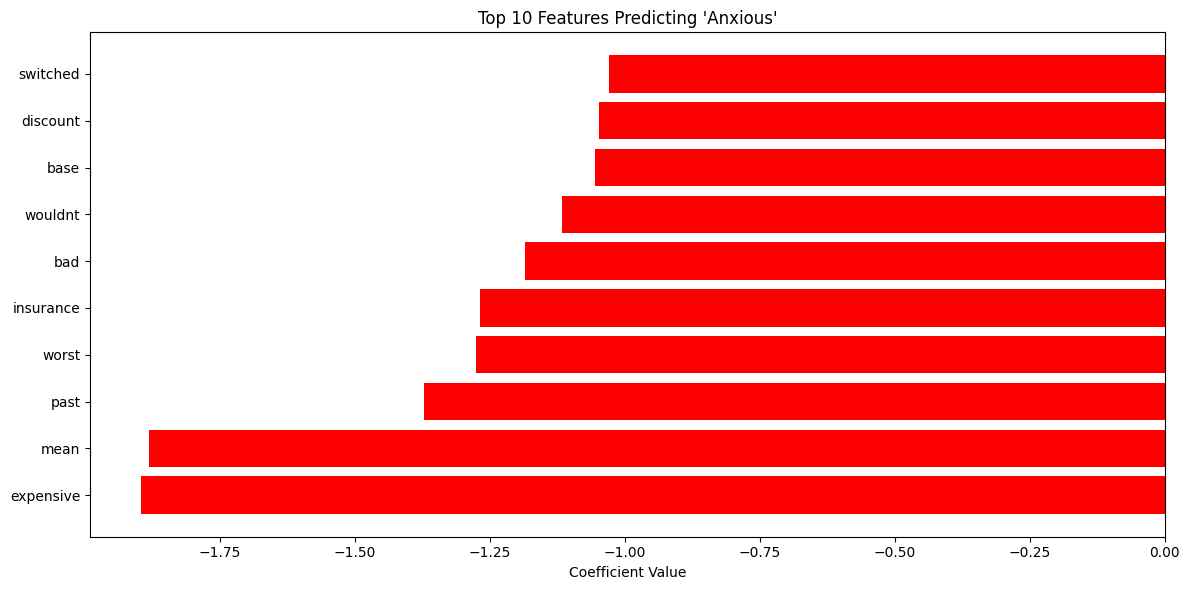

In [ ]:
# Top 10 positive and negative features

top_positive_indices = np.argsort(coefficients)[-10:]
top_negative_indices = np.argsort(coefficients)[:10]

plt.figure(figsize=(12, 6))
plt.barh([feature_names[i] for i in top_positive_indices], coefficients[top_positive_indices], color='green')
plt.title("Top 10 Features Predicting 'Coping'")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.barh([feature_names[i] for i in top_negative_indices], coefficients[top_negative_indices], color='red')
plt.title("Top 10 Features Predicting 'Anxious'")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

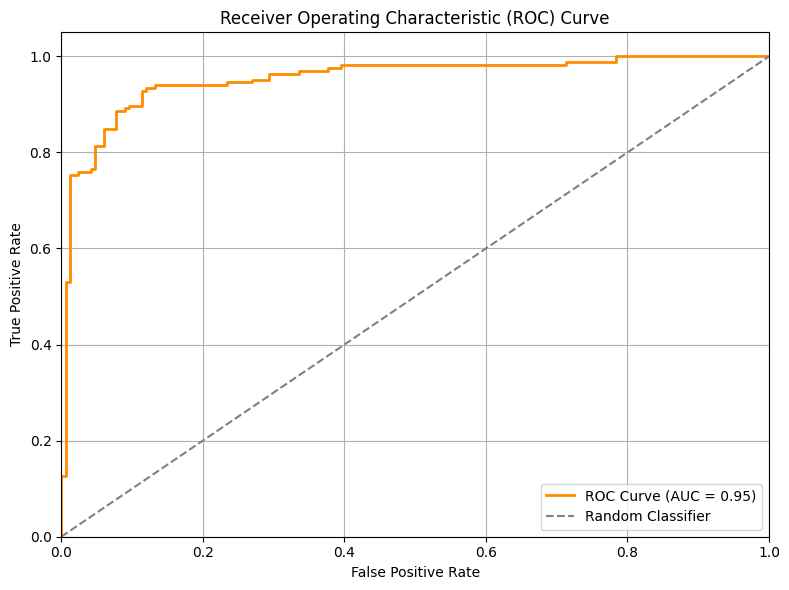

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

# Binarize the labels: 'Anxious' = 1, 'Coping' = 0

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC

fpr, tpr, thresholds = roc_curve(y_test_bin, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()